# Use the JITR Bot to generate context-aware responses

Retrieval Augmented Generation (RAG) has become an industry standard method for interfacing with large language models by making them 'context aware'. However, there are a number of situations where a text generation problem is not solved by interacting with large vector database containing many documents. These problems require context but where the context is not known before query time and is often unrelated to existing vector stores. Usually, they are questions about single documents where desirable behavior is to allow the document to be specified at runtime.

One application that does this fairly well is [DataChad](https://datachad.streamlit.app/), built by DataRobot's own Gustav von Zitzewitz. Datachad works fine for its purpose as a localized web application but it doesn't generalize. In other words, there is not a good way to interact with the application without opening a browser, uploading whatever files you want to analyze, and hitting a run button. 

Rather than follow the standard RAG approach of querying an existing vector store, this accelerator creates a deployment that accepts a file as an argument so that it can provide context aware answers 'on the fly'. DataRobot calls this approach "Just In Time Retrieval", or JITR for short. DataRobot created a Slackbot that uses this deployment as the backend to answer questions when a user uploads a PDF, called the "JITR Bot".

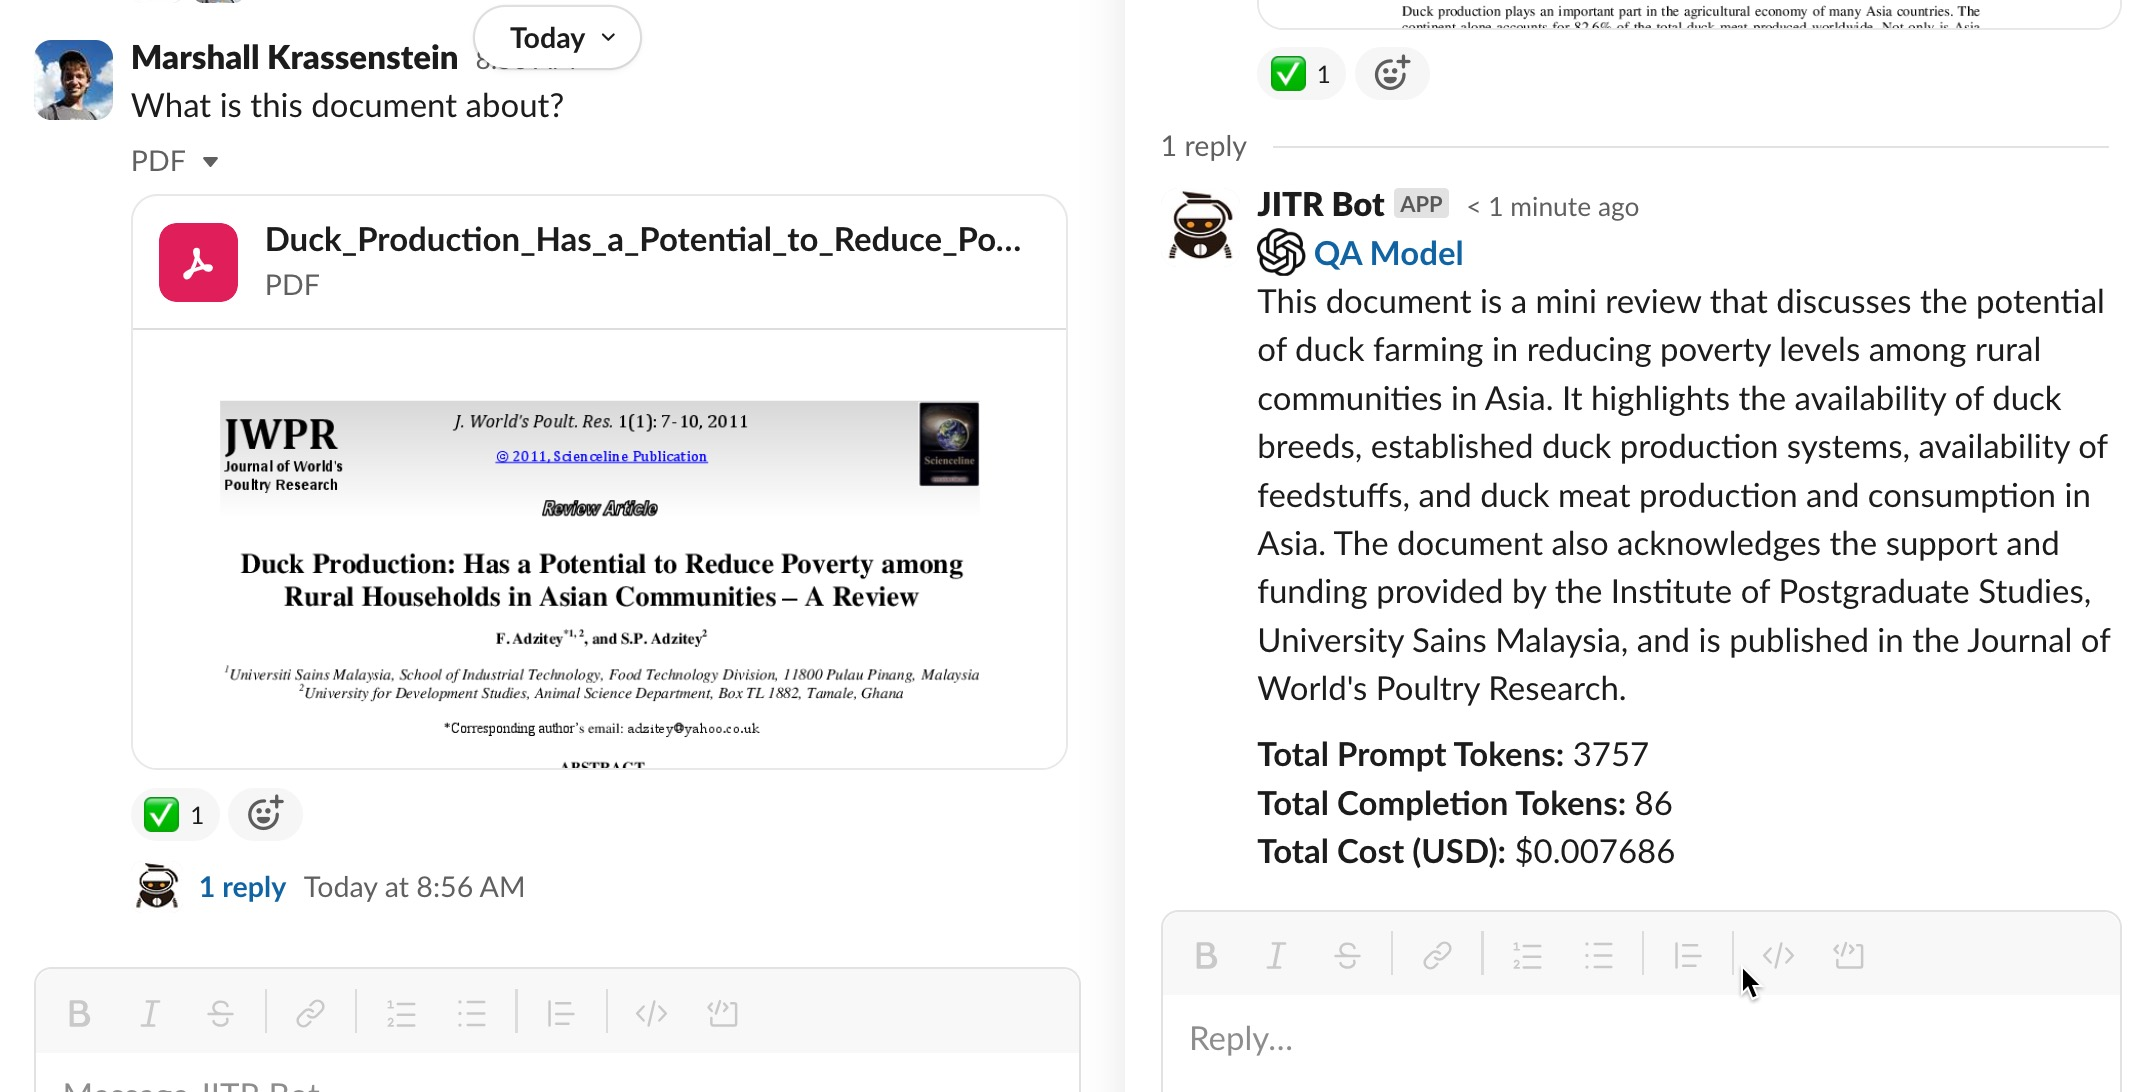

## Setup

**READ BEFORE STARTING THE ACCELERATOR**

1. Enable the following **feature flags** on your account:
    - Enable Notebooks Filesystem Management
    - Enable Proxy models
    - Enable Public Network Access for all Custom Models 
	- Enable the Injection of Runtime Parameters for Custom Models
    - Enable Monitoring Support for Generative Models
    - Enable Custom Inference Models (On by default)
2. Enable the notebook filesystem for this notebook in the notebook sidebar.
3. Add the notebook environment variables `OPENAI_API_KEY`, `OPENAI_ORGANIZATION`,
   `OPENAI_API_BASE` and set the values with your Azure OpenAI credentials.
4. Set the notebook session timeout to 180 minutes.
5. Restart the notebook container using at least a "Medium" (16GB ram) instance.

### Install libraries

In [ ]:
!pip install "langchain==0.0.244" \
"faiss-cpu==1.7.4" \
"sentence-transformers==2.2.2" \
"unstructured==0.8.4" \
"openai==0.27.8" \
"datarobotx==0.1.20" \
"cloudpickle==2.2.1" \
"pypdf==3.15.2" \
"tiktoken" -qq

### Retrieve PDFs

While building and testing the JITR Bot, it is helpful to have some files to work with. You can retrieve PDFs in DataRobot's S3 bucket. They don't have a consistent topic but they should help you get the idea across.

- `datarobot_architecture.pdf`: A two page document on the architecture of the platform.
- `instant_noodels.pdf`: A 45 page manuscript analyzing instant noodles.
- `young_ash_go_west.pdf`: An eight page, fan-made story about Ash and Pikachu.

In [ ]:
import io
import os

import requests

file_mapping = {
    "datarobot_architecture.pdf": "https://s3.amazonaws.com/datarobot_public_datasets/drx/DataRobot+Architecture.pdf",
    "instant_noodles.pdf": "https://s3.amazonaws.com/datarobot_public_datasets/drx/Instantnoodles.pdf",
    "young_ash_go_west.pdf": "https://s3.amazonaws.com/datarobot_public_datasets/drx/young_ash_go_west.pdf",
}

#file paths assume we use dr-notebooks
os.mkdir("./storage/data")
os.chdir('./storage/')

for file in file_mapping:
    with open(f"data/{file}", "wb") as f:
        resp = requests.get(file_mapping[file])
        f.write(resp.content)

Now retrieving the PDFs, specify a PDF as a runtime argument in a remote deployment. To send the content of the PDF file to the deployed model, [base64 encode[(https://builtin.com/software-engineering-perspectives/base64-encoding) the file. This allows data transfer in any language. Two useful functions for encoding and decoding the file are described below.

- `file_to_base_64`: Takes a file path and turn the content of the file into a base64-encoded string. Use this function *outside* of the deployment and pass the result as an argument at runtime.
- `base_64_to_file`: Take a base64-encoded string and write it into a file. Use this function *inside* of a deployment and turn the result into a small vectorstore. 

In [ ]:
import base64
import codecs
import os
from pathlib import Path


def file_to_base_64(filepath: str):
    """
    Convert content of a file path and converts to base64

    Parameters
    ----------
    filepath : str
        Path to a file. In our case, this will be used only for pdfs

    Returns
    -------
    bytes
        Base64 representation of a file
    """
    with open(filepath, "rb") as file:
        encoded_string = base64.b64encode(file.read())
        return encoded_string


def base_64_to_file(b64_string: bytes, filepath: str = "data/temp.pdf") -> str:
    """
    Decode a base64 string and write into a pdf file

    Parameters
    ----------
    b64_string : bytes
        Base64 representation of a file
    filepath : str, default temp.pdf
        Path to write a pdf file

    Returns
    -------
    str
    Path of resulting pdf file
    """
    parent_directory = Path(filepath).parent.absolute()
    if not os.path.exists(parent_directory):
        os.makedirs(parent_directory)

    with open(filepath, "wb") as f:
        f.write(codecs.decode(b64_string, "base64"))
    return filepath


# Convert a file to base64
b64_encoding = file_to_base_64("data/datarobot_architecture.pdf")

# Create a PDF from encoding
base_64_to_file(b64_encoding, filepath="data/temp0.pdf")

# Compare recreated file to original file
b64_encoding_second = file_to_base_64("data/temp0.pdf")

# Quick test that these are the same
assert b64_encoding == b64_encoding

# Remove file
os.remove("data/temp0.pdf")

### Create hooks

With the helper functions defined, you can make the [hooks](https://docs.datarobot.com/en/docs/mlops/deployment/custom-models/custom-model-assembly/custom-model-components.html#model-code). In this case, you just need to define a hook called `load_model` and another hook called `score_unstructured`. `load_model` is defined in the following cell. In `load_model`, you choose the embedding model to use as well as the actual LLM that you will ping with the context aware prompt. The embedding model is common to any RAG workflow and helps you find the most relevent chunks of text to use as context for answering a given question. There is also a small piece of logic to pull OpenAI credentials from the deployment itself so you don't need to supply them every time you make a prediction request.

In [ ]:
OPENAI_API_BASE = os.environ["OPENAI_API_BASE"]
OPENAI_ORGANIZATION = os.environ["OPENAI_ORGANIZATION"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
OPENAI_API_TYPE = os.environ["OPENAI_API_TYPE"]
OPENAI_API_VERSION = os.environ["OPENAI_API_VERSION"]
OPENAI_DEPLOYMENT_NAME = os.environ["OPENAI_DEPLOYMENT_NAME"]


def load_model(input_dir):
    """Custom model hook for loading our embedding model and LLM."""
    import os

    import datarobot_drum as drum
    from langchain.chat_models import AzureChatOpenAI
    from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

    try:
        # Pull credentials from deployment
        key = drum.RuntimeParameters.get("OPENAI_API_KEY")["apiToken"]
    except ValueError:
        # Pull credentials from environment (when running locally)
        key = os.environ.get("OPENAI_API_KEY", "")

    # Embedding model
    embedding_function = SentenceTransformerEmbeddings(
        model_name="all-MiniLM-L6-v2",
        cache_folder=os.path.join(input_dir, "deploy/sentencetransformers"),
    )

    # LLM
    llm = AzureChatOpenAI(
        deployment_name=OPENAI_DEPLOYMENT_NAME,
        openai_api_type=OPENAI_API_TYPE,
        openai_api_base=OPENAI_API_BASE,
        openai_api_version=OPENAI_API_VERSION,
        openai_api_key=OPENAI_API_KEY,
        openai_organization=OPENAI_ORGANIZATION,
        model_name=OPENAI_DEPLOYMENT_NAME,
        temperature=0,
        verbose=True,
    )

    return llm, embedding_function

With your LLM, embedding model, and encoding functions defined, you can build the actual text generation logic of JITR. Each implementation step is outlined below.

1. Load data where `data` is a JSON string consisting of a question and a base64 encoded document
2. Save the document to a temporary file
3. Create a vector store from the temp file:
    - Load file
    - Split into chunks
    - Put in vectorstore
5. Delete the temporary file
6. Define chain
7. Run RAG

In [ ]:
def score_unstructured(model, data, query, **kwargs) -> str:
    """Custom model hook for making completions with our knowledge base.

    When requesting predictions from the deployment, pass a dictionary
    with the following keys:
    - 'question' the question to be passed to the retrieval chain
    - 'document' a base64 encoded document to be loaded into the vector database

    datarobot-user-models (DRUM) handles loading the model and calling
    this function with the appropriate parameters.

    Returns:
    --------
    rv : str
        Json dictionary with keys:
            - 'question' user's original question
            - 'answer' the generated answer to the question
    """
    import json

    from langchain.chains import ConversationalRetrievalChain
    from langchain.document_loaders import PyPDFLoader
    from langchain.vectorstores.base import VectorStoreRetriever
    from langchain.vectorstores.faiss import FAISS

    llm, embedding_function = model
    temp_file_name = "data/temp.pdf"
    data_dict = json.loads(data)

    # Write encoding to file
    base_64_to_file(data_dict["document"].encode(), filepath=temp_file_name)

    # Load up the file
    loader = PyPDFLoader(temp_file_name)
    docs = loader.load_and_split()

    # Remove record when done
    os.remove(temp_file_name)

    # Create our vector database
    texts = [doc.page_content for doc in docs]
    metadatas = [doc.metadata for doc in docs]
    db = FAISS.from_texts(texts, embedding_function, metadatas=metadatas)

    # Define the chain
    retriever = VectorStoreRetriever(vectorstore=db)
    chain = ConversationalRetrievalChain.from_llm(llm, retriever=retriever)

    # Run it
    response = chain(inputs={"question": data_dict["question"], "chat_history": []})
    return json.dumps({"result": response})

Now you can test it locally. When hitting a deployment, DataRobot first calls `load_model` and passes the result as the `model` argument to `score_unstructured`. This tructure is mimicked in the following cell.

In [ ]:
import io
import json

url = "https://s3.amazonaws.com/datarobot_public_datasets/drx/Instantnoodles.pdf"
resp = requests.get(url).content
encoding = base64.b64encode(io.BytesIO(resp).read())

# Test the hooks locally
c = score_unstructured(
    load_model("."),
    json.dumps(
        {
            "question": "What is this document about",
            "document": encoding.decode(),
        }
    ),
    None,
)
c

'{"result": {"question": "What is this document about", "chat_history": [], "answer": "This document is about the processing, quality, and nutritional aspects of instant noodles. It provides information on the various stages of instant noodle production, including mixing, sheeting, cutting, and waving. It also includes figures showing the consumption of instant noodles in different countries."}}'

If everything seems to be working at this point you can deploy the model. [DatarobotX](https://drx.datarobot.com/consume/deploy.html#example-3-thin-monitored-openai-wrapper-with-secret-handling) makes deployment very easy. In the following cell, create a deployment with one function call (specifying the directory with the embedding model, the scoring hooks, a default environment with packages like langchain already installed, and any extra dependencies youneed to install). This will take a few minutes to complete.

In [ ]:
import datetime as dt

import datarobotx as drx

now = dt.datetime.today().strftime("%h-%d-%Y %H:%M")
deployment = drx.deploy(
    "./deploy",
    name=f"JITR Bot - {now}",
    hooks={"score_unstructured": score_unstructured, "load_model": load_model},
    extra_requirements=["pypdf"],
    # Re-use existing environment if you want to change the hook code,
    # and not requirements
    environment_id="64c964448dd3f0c07f47d040",  # GenAI Dropin environment
)

# Deploying custom model
  - Unable to auto-detect model type; any provided paths and files will be
    exported - dependencies should be explicitly specified using
    `extra_requirements` or `environment_id`
  - Preparing model and environment...
  - Using environment [[DataRobot] Python 3.9 GenAI
    v2](https://app.datarobot.com/model-registry/custom-environments/64c964448dd3f0c07f47d040)
    for deployment
  - Configuring and uploading custom model...
    100%|███████████████████████████████████| 91.7M/91.7M [00:00<00:00, 190MB/s]


  - Registered custom model [JITR Bot - Oct-25-2023
    22:17](https://app.datarobot.com/model-registry/custom-models/653993f126830f4ec025c6da/info)
    with target type: Unstructured
  - Installing additional dependencies...


  - Creating and deploying model package...


  - Created deployment [JITR Bot - Oct-25-2023
    22:17](https://app.datarobot.com/deployments/653995d19da96f2431c90516/overview)
# Custom model deployment complete


Now we'll we can hit our deployment and see if it works.

In [ ]:
import datarobotx as drx

# deployment = drx.Deployment("653995d19da96f2431c90516") # if using an existing deployment copy your deployment_id here
response = deployment.predict_unstructured(
    {
        "question": "What does this say about noodle rehydration?",
        "document": encoding.decode(),
    }
)["result"]

# Making predictions
  - Making predictions with deployment [JITR Bot - Oct-25-2023
    22:17](https://app.datarobot.com/deployments/653995d19da96f2431c90516/overview)


# Predictions complete


In [ ]:
response

{'question': 'What does this say about noodle rehydration?',
 'chat_history': [],
 'answer': 'The article mentions that during the frying process, many tiny holes are created due to mass transfer, and they serve as channels for water penetration upon rehydration in hot water. The porous structure created during frying facilitates rehydration.'}

Looks good to me! Lets loop through and ask what each document we downloaded is about.

In [ ]:
prompt = "What is this document about?"
answers = []
for file in file_mapping.keys():
    encoding = file_to_base_64(os.path.join("./data", file))
    response = deployment.predict_unstructured(
        {
            "question": prompt,
            "document": encoding.decode(),
        }
    )["result"]
    print(f"Document: {file}\n---------\nAnswer: {response['answer']}\n")

And since the deployment is in DataRobot, we get a few measures like response time and number of calls tracked for us automatically

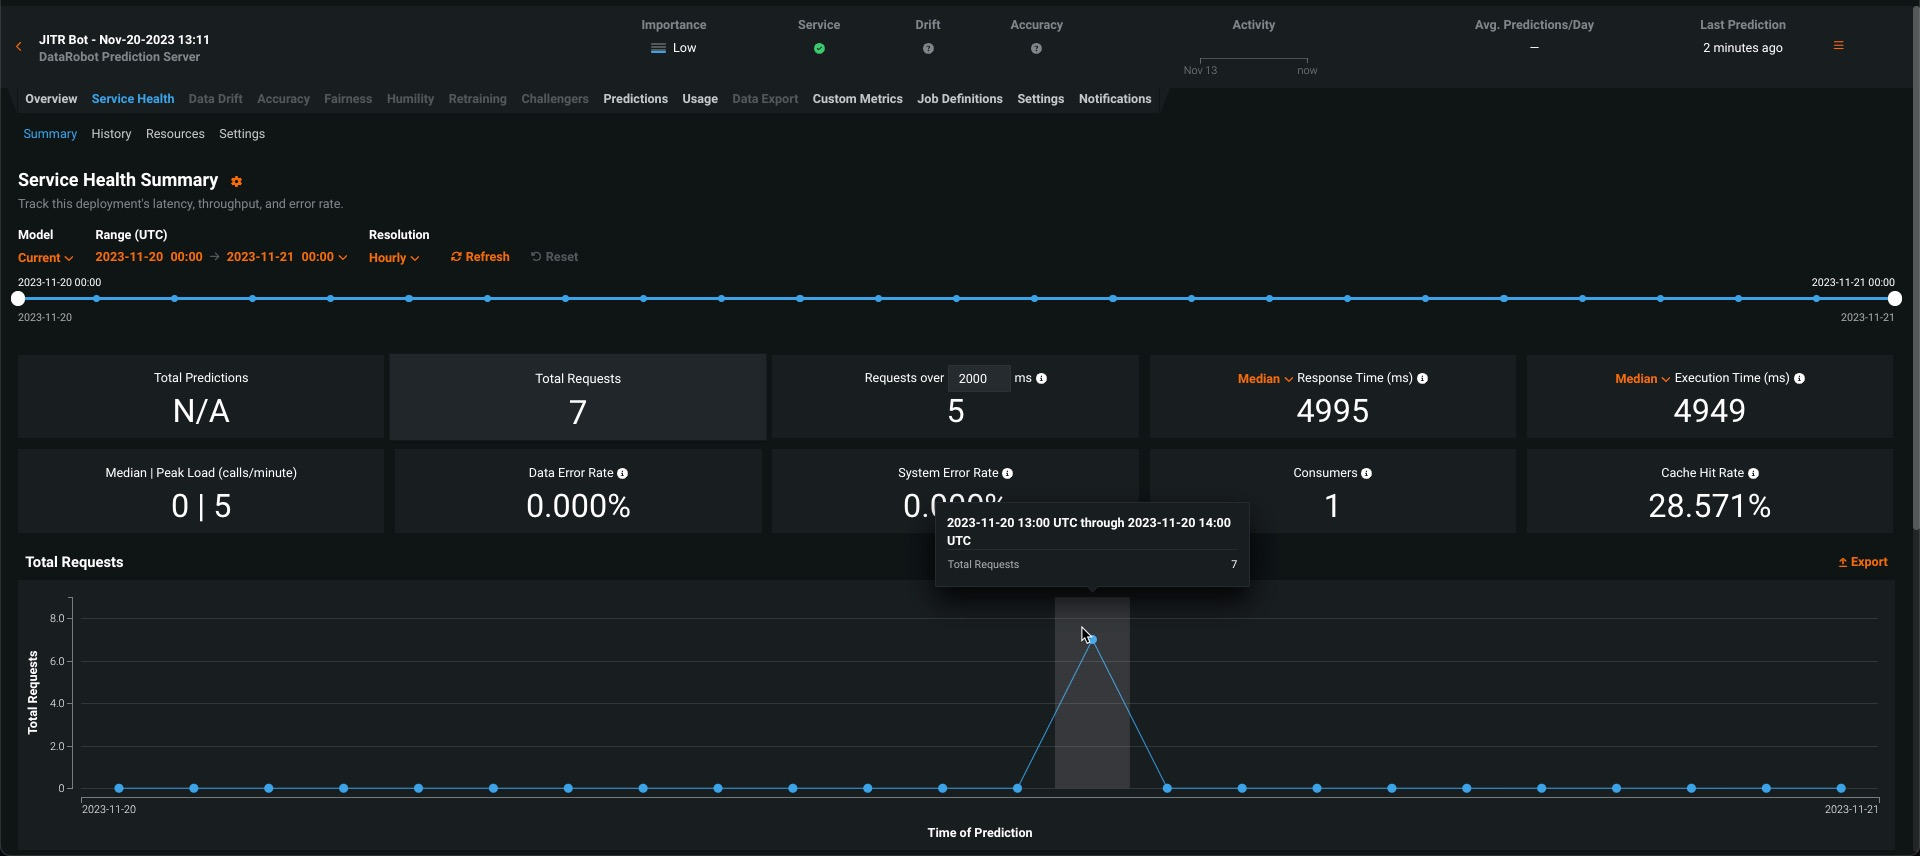

## Conclusion

Just in Time Retrieval is a great approach to use when you need context aware answers for arbitrary documents. This acclerator shows how to build a deployment that accepts an encoded PDF file as an argument. The acclerator addresses the fundamentals, but you can experiment with additional changes outlined below.

- Change the `score_unstructured` logic so that it:
      - Accepts other document types
      - Accepts multiple questions at one time
      - Accepts multiple documents at one time
      - Accepts a 'chain-type' argument so that JITR can respond different for different types of questions
      - Accepts conversation history as an argument
      - Returns things in addition to an answer such as total token count
- Calculate and report measures like token count, cost, readability, confidence etc
- Build a chat front end (such as the JITR Bot screenshot we showed at the beginning of this accelerator)
